# Report on Expungement Outcomes in the Virginia Court Data
**Code for Charlottesville**

*Last updated: 8/9/2021*

### Table of contents
1. [Introduction](#introduction)
2. [Loading the data from our Postgres DB](#loading)
3. [How many records qualify as automatic, automatic (pending), petition, petition (pending), or not expungable, in every by year in the data?](#q1)
4. [How do these counts break down by race?](#q2)
5. [What are the most frequent reasons for each expungability outcome?](#q3)
6. [How do these reasons differ by race?](#q4)

## Introduction <a name="introduction"></a>
Previously, we developed a program to auto-encode every record in the Virginia court data by expungability under the new law: either automatic, petition, automatic or petition pending a mandatory waiting period, or not eligible for expungement. We also automatically coded the reasons for each expungement decision, and phrased the reasons in the language of the new law. We then constructed a loop that applied these auto-encoders to each individuals' records in the Virginia court data. We saved the data in a Postgres database on our Oracle cloud virtual computers.

In this document, we load the data and summarize it in ways that provide answers to the following questions:

1. How many records qualify as automatic, automatic (pending), petition, petition (pending), or not expungeable, in every by year in the data.

2. How do these counts break down by race?

3. What are the most frequent reasons for each expungability outcome?

4. How do these reasons differ by race?

We begin by loading the following Python packages:

In [1]:
import sqlalchemy as sa
from sqlalchemy import create_engine
import psycopg2 as db
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import sidetable
pd.set_option('display.max_colwidth', None)

## Loading the data from our Postgres DB <a name="loading"></a>
First we create a connection to the database:

In [2]:
postPass=os.environ["POSTGRES_PASS"]
try:
    conn = db.connect(host='localhost', database='expunge', user='jupyter', password=postPass, port='5432')
except:
    print("I am unable to connect to the database") 

cur = conn.cursor()
try:
    tables=cur.execute("select * from pg_catalog.pg_tables WHERE schemaname != 'information_schema' AND schemaname != 'pg_catalog';")
    print(cur)
    
except:
    print("I can't drop our test database!")

<cursor object at 0x7fd30ed14750; closed: 0>


Then we use this connection to query the entire dataset. This is memory intensive -- working wholly within SQL would be more efficient. But I choose to work in the Python environment to be able to use `pandas` and the Python plotting packages:

In [5]:
myquery = """
SELECT * FROM data_1k_sample
"""

pd.read_sql(myquery, con=conn)

,person_id,HearingDate,CodeSection,codesection,ChargeType,chargetype,Class,DispositionCode,disposition,Plea,...,within7,within10,class1_2,class3_4,expungable,old_expungable,expungable_no_lifetimelimit,reason,sameday,lifetime
0,199031000000439,2018-06-01,A.46.2-862,covered elsewhere,Misdemeanor,Misdemeanor,NA,Guilty,Conviction,NA,...,TRUE,TRUE,FALSE,FALSE,Automatic (pending),FALSE,Automatic (pending),"Conviction of misdemeanor charges listed in 19.2-392.6 B with no convictions since the disposition date. However, because the disposition date is within 7 years of the current date, the record is not yet eligible for expungement",FALSE,FALSE
1,15100000000316,2000-08-07,18.2-26,covered elsewhere,Felony,Felony,NA,Guilty,Conviction,NA,...,FALSE,FALSE,FALSE,FALSE,Petition,FALSE,Petition,"Conviction or deferred dismissal of felony charges that are not ones listed under 19.2-392.12, with no felonies within the last 10 years, no class 3 or 4 felony conviction within the past 20 years, no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of another kind within 10 years from disposition date",FALSE,FALSE
2,15100000000316,2000-08-07,18.2-95,covered elsewhere,Felony,Felony,NA,Guilty,Conviction,NA,...,FALSE,FALSE,FALSE,FALSE,Petition,FALSE,Petition,"Conviction or deferred dismissal of felony charges that are not ones listed under 19.2-392.12, with no felonies within the last 10 years, no class 3 or 4 felony conviction within the past 20 years, no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of another kind within 10 years from disposition date",FALSE,FALSE
3,10210000000095,2019-09-25,46.2-300,covered elsewhere,Misdemeanor,Misdemeanor,NA,Guilty In Absentia,Conviction,NA,...,TRUE,TRUE,FALSE,FALSE,Automatic (pending),FALSE,Automatic (pending),"Conviction of misdemeanor charges listed in 19.2-392.6 B with no convictions since the disposition date. However, because the disposition date is within 7 years of the current date, the record is not yet eligible for expungement",FALSE,FALSE
4,51220000000305,2010-05-03,46.2-613(2),covered elsewhere,Misdemeanor,Misdemeanor,1,Guilty,Conviction,Guilty,...,FALSE,FALSE,FALSE,FALSE,Automatic,FALSE,Automatic,Conviction of misdemeanor charges listed in 19.2-392.6 B with no convictions within 7 years from disposition date,FALSE,FALSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,150220000000428,2008-05-29,46.2-1052,covered elsewhere,Misdemeanor,Misdemeanor,NA,Dismissed,Dismissed,Not Guilty,...,FALSE,FALSE,FALSE,FALSE,Petition,TRUE,Petition,"Dismissal of misdemeanor charges with no arrests or charges in the past 3 years, but with prior convictions on the person's record",FALSE,FALSE
2807,247010000000986,2009-11-09,4.1-305,covered in 19.2-392.6 - B,Misdemeanor,Misdemeanor,1,Dismissed,Dismissed,NA,...,FALSE,FALSE,FALSE,FALSE,Automatic,TRUE,Automatic,Dismissal of misdemeanor charges with no arrests or charges in the past 3 years and no convictions on the person's record,FALSE,FALSE
2808,51180000000249,2019-06-27,A.46.2-852,covered elsewhere,Misdemeanor,Misdemeanor,1,Guilty,Conviction,NA,...,TRUE,TRUE,FALSE,FALSE,Automatic (pending),FALSE,Automatic (pending),"Conviction of misdemeanor charges listed in 19.2-392.6 B with no convictions since the disposition date. However, because the disposition date is within 7 years of the current date, the record is not yet eligible for expungement",FALSE,FALSE
2809,77150000000685,2013-04-12,B.46.2-301,covered elsewhere,Misdemeanor,Misdemeanor,1,Guilty,Conviction,NA,...,FALSE,TRUE,FALSE,FALSE,Automatic,FALSE,Automatic,Conviction of misdemeanor charges listed in 19.2-392.6 B with no convictions within 7 years from disposition date,FALSE,FALSE


In [4]:
res <- dbSendQuery(con, "SELECT * FROM data_1k_sample")
df_1k <- dbFetch(res)
print(nrow(df_1k))
head(df_1k)

NameError: name 'res' is not defined

In [3]:
myquery = """
SELECT * FROM public.expunge
"""
courtdata = pd.read_sql(myquery, con=conn)
courtdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313136 entries, 0 to 8313135
Data columns (total 14 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   rperson_id       object
 1   HearingDate      object
 2   CodeSection      object
 3   ChargeType       object
 4   Class            object
 5   DispositionCode  object
 6   Plea             object
 7   Race             object
 8   Sex              object
 9   fips             object
 10  Locality         object
 11  expungable       object
 12  reason           object
 13  old_expungable   object
dtypes: object(14)
memory usage: 887.9+ MB


In [4]:
len(courtdata['rperson_id'].unique())

2831453

In [5]:
#Under

The resulting data contain 8,313,136 distinct records from 2,831,453 different people over the time frame from 2000 to 2020. The first few rows of the data look like this:

In [6]:
courtdata.head()

,rperson_id,HearingDate,CodeSection,ChargeType,Class,DispositionCode,Plea,Race,Sex,fips,Locality,expungable,reason,old_expungable
0,100000000000001,2010-08-25,18.2-250.1,Misdemeanor,U,Nolle Prosequi,NA,Black(Non-Hispanic),Male,87,COMMONWEALTH OF VA,Automatic,Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years,TRUE
1,124200000000013,2016-04-11,A.46.2-852,Misdemeanor,NA,Dismissed,NA,White Caucasian(Non-Hispanic),Male,153,PRINCE WILLIAM CO,Automatic,Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years,TRUE
2,124200000000014,2013-09-19,A.46.2-862,Misdemeanor,NA,Guilty,NA,Hispanic,Male,153,COMMONWEALTH OF VA,Petition,"Conviction of misdemeanor charges other than those covered under 19.2-392.6-A, 19.2-392.6-B, and 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date",FALSE
3,124200000000014,2016-09-15,A.46.2-862,Misdemeanor,NA,Guilty In Absentia,NA,Hispanic,Male,25,COUNTY OF BRUNSWICK,Petition (pending),"Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date",FALSE
4,100000000000004,2018-01-10,18.2-111,Felony,O,Nolle Prosequi,NA,White Caucasian(Non-Hispanic),Male,510,COMMONWEALTH OF VA,Not eligible,"Not convicted, felony charge covered in a section other than 19.2-392.12",TRUE


## How many records qualify as automatic, automatic (pending), petition, petition (pending), or not expungable, in every by year in the data? <a name="q1"></a>

NA    8313136
Name: Plea, dtype: int64

First we extract year from the `HearingDate` column:

In [7]:
courtdata['year'] = pd.DatetimeIndex(pd.to_datetime(courtdata['HearingDate'], errors='coerce')).year

There were several errors in how hearing date was entered into the data, with some nonsensical, future years:

In [8]:
courtdata.year.value_counts()

2009.0    746312
2010.0    724921
2011.0    715787
2012.0    698995
2013.0    682232
2014.0    660182
2015.0    623711
2017.0    613154
2019.0    612489
2018.0    608076
2016.0    600545
2007.0    123085
2008.0    122305
2006.0    117143
2002.0    111056
2004.0    111011
2003.0    109274
2005.0    108574
2001.0    107690
2000.0    103130
2020.0     12077
2021.0       691
2022.0       245
2023.0        92
2025.0        57
2024.0        57
2028.0        56
2026.0        35
2029.0        28
2027.0        22
2031.0        14
2030.0        13
2033.0        11
2040.0         6
2048.0         6
2037.0         4
2041.0         4
2045.0         4
2044.0         4
2038.0         3
2058.0         3
2042.0         3
2065.0         3
2060.0         3
2032.0         2
2034.0         2
2054.0         2
2047.0         2
2050.0         2
2035.0         2
2043.0         2
2039.0         1
2059.0         1
2051.0         1
2062.0         1
2049.0         1
2036.0         1
2052.0         1
2055.0        

We replace these future years with missing values for now, until we can dig into the data to see what went wrong with these codes:

In [15]:
courtdata.year[courtdata.year > 2020] = np.nan

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The following table lists **raw counts** of each expungability outcome by year:

In [16]:
pd.crosstab(courtdata.year, courtdata.expungable)

expungable,Automatic,Automatic (pending),Not eligible,Petition,Petition (pending)
year,,,,,
2000.0,4476,690,74514,16598,6852
2001.0,4144,687,79475,16621,6763
2002.0,3794,673,83140,16471,6978
2003.0,3531,692,83032,15135,6884
2004.0,2910,593,88315,12977,6216
2005.0,2662,543,87155,12204,6010
2006.0,2461,727,94959,12666,6330
2007.0,2843,623,98169,14368,7082
2008.0,2609,739,98226,13282,7449


And this table lists **the row percents** -- out of all records in each year, what percent falls within each expungability outcome?

In [17]:
rowtable = (pd.crosstab(courtdata.year, courtdata.expungable, normalize='index')*100).round(2).reset_index()
rowtable

expungable,year,Automatic,Automatic (pending),Not eligible,Petition,Petition (pending)
0,2000.0,4.34,0.67,72.25,16.09,6.64
1,2001.0,3.85,0.64,73.80,15.43,6.28
2,2002.0,3.42,0.61,74.86,14.83,6.28
3,2003.0,3.23,0.63,75.99,13.85,6.30
4,2004.0,2.62,0.53,79.56,11.69,5.60
5,2005.0,2.45,0.50,80.27,11.24,5.54
6,2006.0,2.10,0.62,81.06,10.81,5.40
7,2007.0,2.31,0.51,79.76,11.67,5.75
8,2008.0,2.13,0.60,80.31,10.86,6.09
9,2009.0,9.26,2.52,28.62,38.69,20.92


We can also plot these percentages over time:

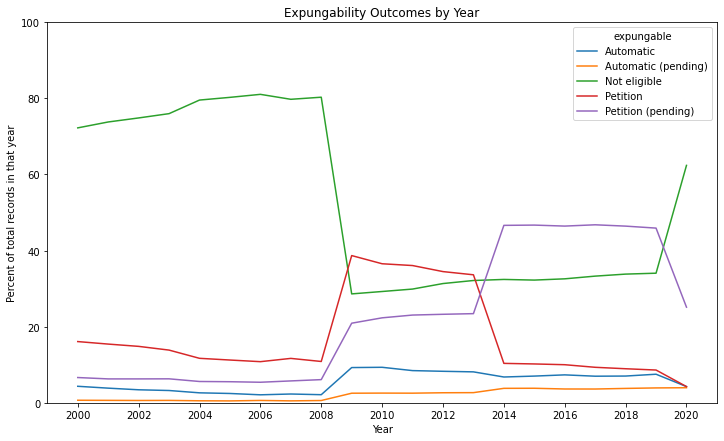

In [18]:
lineplot = pd.melt(rowtable,
                  id_vars = ['year'],
                  value_vars = ['Automatic', 'Automatic (pending)',
                                'Not eligible', 'Petition', 'Petition (pending)'])

plt.figure(figsize=(12,7))
sns.lineplot(x='year', y='value', hue='expungable',data=lineplot)
plt.ylabel('Percent of total records in that year')
plt.xlabel('Year')
plt.title('Expungability Outcomes by Year')
plt.ylim(0,100)
plt.locator_params(axis="x", integer=True, tight=True, nbins=20)

## How do these counts break down by race? <a name="q2"></a>
Race is coded in the data, but in an inconsistent way:

In [12]:
courtdata.stb.freq(['Race'])

,Race,count,percent,cumulative_count,cumulative_percent
0,White Caucasian(Non-Hispanic),3221745,38.754869,3221745,38.754869
1,Black(Non-Hispanic),2291063,27.559552,5512808,66.314421
2,White Caucasian (Non-Hispanic),1174202,14.124658,6687010,80.439079
3,Black (Non-Hispanic),922448,11.096270,7609458,91.535348
4,Hispanic,264701,3.184129,7874159,94.719478
5,Other(Includes Not Applicable.. Unknown),99609,1.198212,7973768,95.917690
6,White,93421,1.123776,8067189,97.041465
7,Asian Or Pacific Islander,80618,0.969766,8147807,98.011232
8,Black,65727,0.790640,8213534,98.801872
9,NA,50056,0.602131,8263590,99.404003


We have to combine and collapse these categories to get a clear picture of how expungability outcomes depend on race:

In [19]:
replace_map = {'Black(Non-Hispanic)':'Black (Non-Hispanic)', 
               'White Caucasian(Non-Hispanic)':'White (Non-Hispanic)', 
               'Other(Includes Not Applicable.. Unknown)':'Other',
               'White Caucasian (Non-Hispanic)':'White (Non-Hispanic)',
               'Unknown (Includes Not Applicable.. Unknown)':'Other', 
               'NA':'Other',
               'Asian Or Pacific Islander':'Asian or Pacific Islander', 
               'Black (Non-Hispanic)':'Black (Non-Hispanic)', 
               'White':'White (Non-Hispanic)',
               'American Indian':'American Indian or Alaskan Native', 
               'Unknown':'Other',
               'Other (Includes Not Applicable.. Unknown)':'Other', 
               'Black':'Black (Non-Hispanic)',
               'American Indian or Alaskan Native':'American Indian or Alaskan Native',
               'American Indian Or Alaskan Native':'American Indian or Alaskan Native', 
               'Asian or Pacific Islander':'Asian or Pacific Islander'}
courtdata.Race = courtdata.Race.replace(replace_map)

In [20]:
courtdata.stb.freq(['Race'])

,Race,count,percent,cumulative_count,cumulative_percent
0,White (Non-Hispanic),4489368,54.003303,4489368,54.003303
1,Black (Non-Hispanic),3279238,39.446462,7768606,93.449764
2,Hispanic,264701,3.184129,8033307,96.633894
3,Other,190496,2.291506,8223803,98.925400
4,Asian or Pacific Islander,81063,0.975119,8304866,99.900519
5,American Indian or Alaskan Native,8270,0.099481,8313136,100.000000


## Note to holden:
<i>could be interesting to pull in census information about state averages for race in virginia to use as a point of comparison between how many black people are in this criminal history list vs how many black people live in Virginia</i>

We can now generate a cross-tabulation of race and expungability outcome. The following table contains row percents: of all records from a person of the given race, what percent falls within each expungability outcome?

### Note to holden:
<i> - what this is saying: for each race, what percentage of those races fall into a certain category for expungeability: not eligilble, automatic petition, etc... <br>
    important thing to clarify: these percentages are just within each category -- so of all the white people with criminal records, 8.5% of thsoe records are under the automatic category, 2.92% are automatic (pending) 35.99% are not eligible, etc. <br>
    - quickly looking at the rest of these, black (non-hispanic) has the most "not eligible" with white (non-hispanic) having hte second most, by percentage  ... interesting to look at that by percentage because it could indicate something systemic: more black people are being convicted (or at least charged) for crimes that are more severe than other races <br>
    - another interesting thing that jumped out to me is the really high petition counts for hispanic and american indian / alaskan native across both petition and petition (pending) ... the reason why this is potentially problematic is based on the difficulties that come along with finding legal representation to actually petition this process ... if these groups are poor on average in the state of virginia, even if the law allows them to petition for expungement, then the likelihood of them ever actually petitioning seems low.
</i>

In [21]:
rowtable = (pd.crosstab(courtdata.Race, courtdata.expungable, normalize='index')*100).round(2).reset_index()
rowtable

expungable,Race,Automatic,Automatic (pending),Not eligible,Petition,Petition (pending)
0,American Indian or Alaskan Native,11.06,1.38,15.95,30.83,40.77
1,Asian or Pacific Islander,14.27,2.32,19.05,29.41,34.95
2,Black (Non-Hispanic),5.30,3.00,43.38,18.74,29.58
3,Hispanic,6.12,1.20,8.77,33.11,50.79
4,Other,10.79,1.83,13.02,26.37,48.00
5,White (Non-Hispanic),8.50,2.92,35.99,22.07,30.52


We can plot these percents:

<AxesSubplot:xlabel='Race', ylabel='value'>

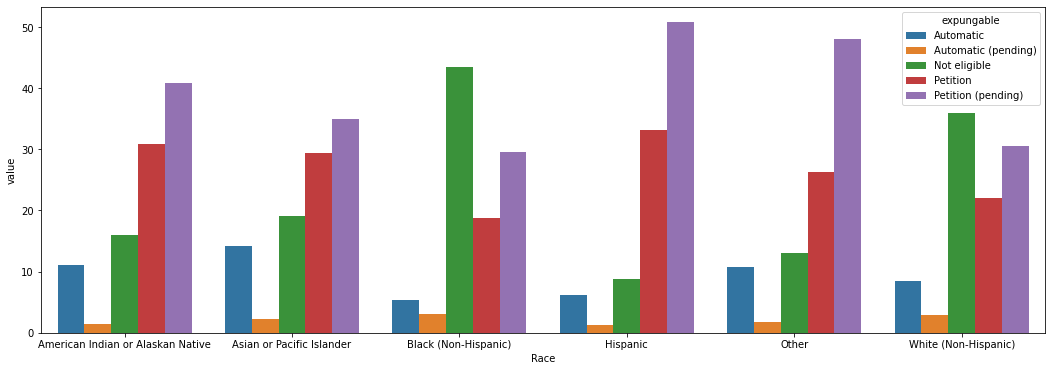

In [22]:
barplot = pd.melt(rowtable,
                  id_vars = ['Race'],
                  value_vars = ['Automatic', 'Automatic (pending)',
                                'Not eligible', 'Petition', 'Petition (pending)'])

plt.figure(figsize=(18, 6))
sns.barplot(x='Race', y='value', hue='expungable', data=barplot)

### note to holden:
<i>
    - the biggest thing here that jumps out is just how small the percentage value of "automatic (pending)" is across all the races! it's great that there is going to be this new push for automatic but man if it's affecting this few people then who cares? the vast majority of these cases still fall to either petition (people could petition right now) or petition pending (people can petition once the new law is enacted in 2025) ... this means that +50% of people will still have to find representation and navigate the legal process themselves in order to get their record expunged <br>
    - my first thought from that is that we need to bump up the # of things that are considered automatic for expungement <br>
    - if that's not possible then we need to look deeper at what the petition process for expungement really looks like and how that could adversely affect people based on socio-economic status ... https://casetext.com/statute/code-of-virginia/title-192-criminal-procedure/chapter-232-sealing-of-criminal-history-record-information-and-court-records/section-192-39212-sealing-of-offenses-resulting-in-a-deferred-and-dismissed-disposition-or-conviction-by-petition <br>
    ^ that is information from the virginia statute that discusses the process around petitioning 
</i>

## What are the most frequent reasons for each expungability outcome? <a name="q3"></a>
We can assess the most common reasons for each expungability decision:

In [23]:
reasons = pd.DataFrame(courtdata.groupby(['expungable', 'reason']).size())
reasons = reasons.rename({0:'count'}, axis=1)

autoex = reasons.query("expungable == 'Automatic'")
autoex = autoex.assign(percent = round(100*(autoex['count'] / sum(autoex['count'])), 2))

autopend = reasons.query("expungable == 'Automatic (pending)'")
autopend = autopend.assign(percent = round(100*(autopend['count'] / sum(autopend['count'])), 2))

petex = reasons.query("expungable == 'Petition'")
petex = petex.assign(percent = round(100*(petex['count'] / sum(petex['count'])), 2))

petpend = reasons.query("expungable == 'Petition (pending)'")
petpend = petpend.assign(percent = round(100*(petpend['count'] / sum(petpend['count'])), 2))

notex = reasons.query("expungable == 'Not eligible'")
notex = notex.assign(percent = round(100*(notex['count'] / sum(notex['count'])), 2))

In [26]:
# how many unique reasons are there total
print(len(reasons))

# what are those unique reasons?
reasons

25


count
expungable          reason                                                                                                                                                                                                                                                                                                                                                                                   
Automatic           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                    43762
                    Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                                    561002
Automatic (pending) Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                     4401
                    Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                               192673
                    Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                                     41214
Not eligible        Conviction and convicted of another felony within the past 10 years of the petition                                                                                                                                                                                                                                                                                               1735581
                    Conviction of felony charges that are not covered in section 19.2-392.12                                                                                                                                                                                                                                                                                                              160
                    Conviction of misdemeanor charges covered under 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                                      3826
                    Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                                 3848
              

In [27]:
autoex.sort_values('count', ascending=False)

count  \
expungable reason                                                                                                                                                                                                                                                                                                                                                     
Automatic  Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                   561002   
           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date   43762   

                                                                                                                                                                                                                                                                                                                                                             percent  
expungable reason                                                                                                                                                                                                                                                                                                                                                     
Automatic  Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                     92.76  
           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date     7.24

In [28]:
autopend.sort_values('count', ascending=False)

count  \
expungable          reason                                                                                                                                                                                                                                                                                                                                                     
Automatic (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                              192673   
                    Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                    41214   
                    Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date    4401   

                                                                                                                                                                                                                                                                                                                                                                      percent  
expungable          reason                                                                                                                                                                                                                                                                                                                                                     
Automatic (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                80.86  
                    Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                     17.30  
                    Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date     1.85

In [29]:
petex.sort_values('count', ascending=False)

count  \
expungable reason                                                                                                                                                                                                                                                                                                                                                                                     
Petition   Conviction of misdemeanor charges other than those covered under 19.2-392.6-A, 19.2-392.6-B, and 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date  897257   
           Not convicted, misdemeanor, but prior convictions on the person's record                                                                                                                                                                                                                                                                                                          865456   
           Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                                     3771   
           Not convicted, felony charge covered in 19.2-392.12                                                                                                                                                                                                                                                                                                                                 1718   
           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                    1447   
           Dismissal of misdemeanor charges with no prior convictions on the person's record, but with arrests or charges in the past 3 years                                                                                                                                                                                                                                                     3   
           Conviction of felony charges covered in section 19.2-392.12, and has not been convicted of any other felony within the past 10 years of the petition, with no class 3 or 4 felony conviction within the past 20 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life                                                                              1   

                                                                                                                                                                                                                                                                                                                                                                                             percent  
expungable reason                                                                                                                                                                                                                                                                                                                                                                                     
Petition   Conviction of misdemeanor charges other than those covered under 19.2

### Note to holden
<i> 
    - does the state of VA keep records of percentages of people who have petitioned and then been rejected/accepted for expungement? because if the numbers for the first option (that comprise 50.70% of all the Petition instances in the last 20 years) are like 100% acceptance for petition of expungement if the person doesn't have a criminal record, shouldn't this just be added to the automatic category instead of requiring the person to go through the legal process? seems exclusionary <br>
- that one might be tricky but a better example (although it definitely applies to less people) is for those not convicted or dimissed or whatever) and who just ogt a charge ... would love to know how many of those petitions are rejected and why 
</i> 



<br><br>
Now looking here: there are +2M isntances of petition pending for the first reason - that's a lot of people! i'm just getting increasingly confident that the answer to these problems lies in building out an automatic procedure for pushing people through the petition process

In [30]:
petpend.sort_values('count', ascending=False)

count  \
expungable         reason                                                                                                                                                                                                                                                                                                                                                                                      
Petition (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                              2002502   
                   Not convicted, misdemeanor, but prior convictions on the person's record                                                                                                                                                                                                                                                                                                           532526   
                   Conviction of misdemeanor charges other than those covered under 19.2-392.6-A, 19.2-392.6-B, and 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date    61569   
                   Not convicted, felony charge covered in 19.2-392.12                                                                                                                                                                                                                                                                                                                                   884   
                   Conviction of felony charges covered in section 19.2-392.12, but has been convicted of another felony within the past 10 years of the petition, with no class 3 or 4 felony conviction within the past 20 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life                                                                                     1   
                   Dismissal of misdemeanor charges with no prior convictions on the person's record, but with arrests or charges in the past 3 years                                                                                                                                                                                                                                                      1   

                                                                                                                                                                                                                                                                                                                                                                                                     percent  
expungable         reason                                                                                                                                                                                                                                                                                                                                                                                     
Petition (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                                7

In [31]:
notex.sort_values('count', ascending=False)

count  \
expungable   reason                                                                                                                                                                                                                                                                                                                                     
Not eligible Conviction and convicted of another felony within the past 10 years of the petition                                                                                                                                                                                                                                              1735581   
             Not convicted, felony charge covered in a section other than 19.2-392.12                                                                                                                                                                                                                                                          973140   
             Conviction with a prior class 3 or 4 felony conviction within the past 20 years                                                                                                                                                                                                                                                   373790   
             Conviction, previously convicted of a class 1 or 2 felony or any other felony punishable by imprisonment for life                                                                                                                                                                                                                  12603   
             Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                3848   
             Conviction of misdemeanor charges covered under 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date     3826   
             Conviction of felony charges that are not covered in section 19.2-392.12                                                                                                                                                                                                                                                             160   

                                                                                                                                                                                                                                                                                                                                              percent  
expungable   reason                                                                                                                                                                                                                                                                                                                                    
Not eligible Conviction and convicted of another felony within the past 10 years of the petition                                                                                                                                                                                                                                                55.93  
             Not convicted, felony charge covered in a section other than 19.2-392.12                                                                                                                 

## How do these reasons differ by race?  <a name="q4"></a>

In [32]:
reasons = pd.DataFrame(courtdata.groupby(['expungable', 'reason', 'Race']).size().unstack())
reasons = reasons.rename({0:'count'}, axis=1)

In [33]:
autoex = reasons.query("expungable == 'Automatic'")
autoex = (100. * autoex / autoex.sum()).round(0)

autopend = reasons.query("expungable == 'Automatic (pending)'")
autopend = (100. * autopend / autopend.sum()).round(0)

petex = reasons.query("expungable == 'Petition'")
petex = (100. * petex / petex.sum()).round(0)

petpend = reasons.query("expungable == 'Petition (pending)'")
petpend = (100. * petpend / petpend.sum()).round(0)

notex = reasons.query("expungable == 'Not eligible'")
notex = (100. * notex / notex.sum()).round(0)

In [36]:
autoex.sort_values('White (Non-Hispanic)', ascending=False)

Race                                                                                                                                                                                                                                                                                                                                                         American Indian or Alaskan Native  \
expungable reason                                                                                                                                                                                                                                                                                                                                                                                
Automatic  Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                                96.0   
           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                4.0   

Race                                                                                                                                                                                                                                                                                                                                                         Asian or Pacific Islander  \
expungable reason                                                                                                                                                                                                                                                                                                                                                                        
Automatic  Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                        96.0   
           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                        4.0   

Race                                                                                                                                                                                                                                                                                                                                                         Black (Non-Hispanic)  \
expungable reason                                                                                                                                                                                                                                                                                                                                                                   
Automatic  Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                          

In [37]:
autopend.sort_values('White (Non-Hispanic)', ascending=False)

Race                                                                                                                                                                                                                                                                                                                                                                  American Indian or Alaskan Native  \
expungable          reason                                                                                                                                                                                                                                                                                                                                                                                
Automatic (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                           67.0   
                    Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                                30.0   
                    Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                4.0   

Race                                                                                                                                                                                                                                                                                                                                                                  Asian or Pacific Islander  \
expungable          reason                                                                                                                                                                                                                                                                                                                                                                        
Automatic (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                   66.0   
                    Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                        31.0   
                    Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                        3.0   

Race                                                                                    

In [38]:
petex.sort_values('White (Non-Hispanic)', ascending=False)

Race                                                                                                                                                                                                                                                                                                                                                                                         American Indian or Alaskan Native  \
expungable reason                                                                                                                                                                                                                                                                                                                                                                                                                
Petition   Conviction of misdemeanor charges other than those covered under 19.2-392.6-A, 19.2-392.6-B, and 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                               78.0   
           Not convicted, misdemeanor, but prior convictions on the person's record                                                                                                                                                                                                                                                                                                                                       22.0   
           Conviction of misdemeanor charges covered under 19.2-392.6-A or 19.2-392.6-B, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                                                0.0   
           Dismissal of misdemeanor charges with no prior convictions on the person's record and no arrests or charges in the past 3 years                                                                                                                                                                                                                                                                                 0.0   
           Dismissal of misdemeanor charges with no prior convictions on the person's record, but with arrests or charges in the past 3 years                                                                                                                                                                                                                                                                              NaN   
           Not convicted, felony charge covered in 19.2-392.12                                                                                                                                                                                                                                                                                                                                                             0.0   
           Conviction of felony charges covered in section 19.2-392.12, and has not been convicted of any other felony within the past 10 years of the petition, with no class 3 or 4 felony conviction within the past 20 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life                                                                                                       NaN   

Race                                                                                                                                                                                                                                         

In [39]:
petpend.sort_values('White (Non-Hispanic)', ascending=False)

Race                                                                                                                                                                                                                                                                                                                                                                                                 American Indian or Alaskan Native  \
expungable         reason                                                                                                                                                                                                                                                                                                                                                                                                                
Petition (pending) Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                                                                           91.0   
                   Not convicted, misdemeanor, but prior convictions on the person's record                                                                                                                                                                                                                                                                                                                                        7.0   
                   Conviction of misdemeanor charges other than those covered under 19.2-392.6-A, 19.2-392.6-B, and 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                1.0   
                   Conviction of felony charges covered in section 19.2-392.12, but has been convicted of another felony within the past 10 years of the petition, with no class 3 or 4 felony conviction within the past 20 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life                                                                                                             NaN   
                   Not convicted, felony charge covered in 19.2-392.12                                                                                                                                                                                                                                                                                                                                                             NaN   
                   Dismissal of misdemeanor charges with no prior convictions on the person's record, but with arrests or charges in the past 3 years                                                                                                                                                                                                                                                                              NaN   

Race                                                                                                                                                                                                                                                                                                                                                                                                 Asian or Pacific Islander  \
expungable         reason                                                                                                                                                    

In [40]:
notex.sort_values('White (Non-Hispanic)', ascending=False)

Race                                                                                                                                                                                                                                                                                                                                          American Indian or Alaskan Native  \
expungable   reason                                                                                                                                                                                                                                                                                                                                                               
Not eligible Conviction and convicted of another felony within the past 10 years of the petition                                                                                                                                                                                                                                                                           61.0   
             Not convicted, felony charge covered in a section other than 19.2-392.12                                                                                                                                                                                                                                                                                      27.0   
             Conviction with a prior class 3 or 4 felony conviction within the past 20 years                                                                                                                                                                                                                                                                               11.0   
             Conviction of felony charges that are not covered in section 19.2-392.12                                                                                                                                                                                                                                                                                       NaN   
             Conviction of misdemeanor charges covered under 19.2-392.12, with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, and no convictions of any other kind within 7 years from disposition date                                0.0   
             Conviction of misdemeanor charges with no class 3 or 4 felony conviction within the past 20 years, no felony within the past 10 years, and no class 1 or 2 felony or any other felony punishable by imprisonment for life, but with convictions of another kind within 7 years from disposition date                                                           0.0   
             Conviction, previously convicted of a class 1 or 2 felony or any other felony punishable by imprisonment for life                                                                                                                                                                                                                                              0.0   

Race                                                                                                                                                                                                                                                                                                                                          Asian or Pacific Islander  \
expungable   reason                                                                                                                                                                                                                                                                                      

### Note to holden
<i> 
    it would be helpful to have another table that shows the percentage of races across eligibility reasons ...
i'm not sure how to build that but it would be interesting to see if some races are affected by certain categories/reasons of expungemenet or ineligibility more than others
</i>